In [1]:
# load the libraries here
import os

datadir = "../jellybean-data"
if not os.path.exists(datadir):
    import sys
    !{sys.executable} -m pip install gitpython
    from git import Repo
    Repo.clone_from(r"git@github.com:srvanderplas/jellybean_data.git", r"../jellybean-data")


In [2]:
# path to images
path_to_data =  r"../jellybean-data"

In [3]:
# get the folder names
folders = os.listdir(path_to_data)

In [4]:
# see what's in folders
folders[:5]

['very_cherry',
 'cappuchino',
 'plum',
 'mixed_berry_smoothie',
 'strawberry_daquiry']

In [5]:
# visualize some sample images
images = os.listdir(os.path.join(path_to_data, folders[1]))

In [6]:
# how many images
len(images)

13

In [7]:
# first 5 in the images vector
images[:5]

['DSC_0012.JPG',
 'DSC_0006.JPG',
 'DSC_0005.JPG',
 'DSC_0013.JPG',
 'DSC_0010.JPG']

In [8]:
# matplotlib for plotting
import matplotlib.pyplot as plt

In [9]:
# status bar
from tqdm.notebook import tqdm

In [10]:
# Now Let's work with developing the watershed idea with one image
# and hopefully generalize that to the others

In [11]:
# read a sample image
img = plt.imread(os.path.join(os.path.join(path_to_data, folders[1]), images[9]))

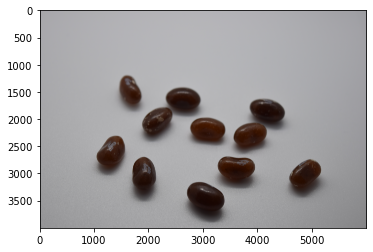

In [12]:
# show a sample image
plt.imshow(img)
plt.show()

In [13]:
# skimage - RGB, CV2 - BGR
import skimage 

In [14]:
# otsu import
from skimage.filters import threshold_otsu
# 3-D to 2-D
from skimage.color import rgb2gray, rgb2hsv, rgb2yuv

In [15]:
# make the image grayscale
gray_image = rgb2gray(img) 

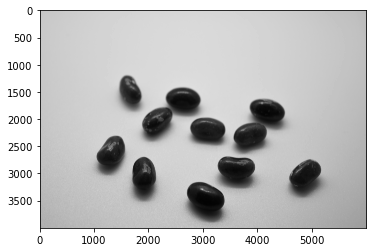

In [16]:
# see the grayscale image
plt.imshow(gray_image, "gray")
plt.show()

In [17]:
# get the otsu thresholding
img_threshold = threshold_otsu(gray_image)

In [18]:
# otsu value
img_threshold

0.4169673828125

In [19]:
# threshold the image
binary = gray_image > img_threshold

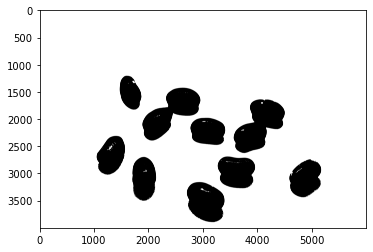

In [20]:
# show the image
plt.imshow(binary, "gray")
plt.show()

In [21]:
# invert? 
binary_invert = 1 - binary

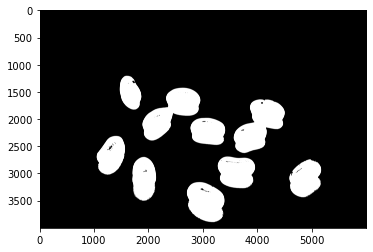

In [22]:
# see the inverted the image
plt.imshow(binary_invert, "gray")
plt.show()

In [23]:
# for filling the small holes
from scipy import ndimage

In [24]:
# fill small holes
binary_invert_filled = ndimage.binary_fill_holes(binary_invert).astype(int)

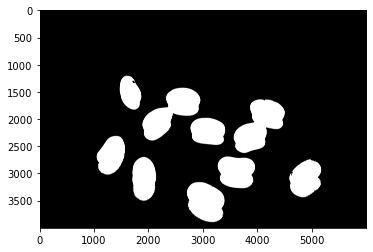

In [25]:
# some can be connected with the border
plt.imshow(binary_invert_filled, "gray")
plt.show()

In [26]:
# clear the border
from skimage.segmentation import clear_border

In [27]:
# clear the border
clear_border = clear_border(binary_invert_filled)

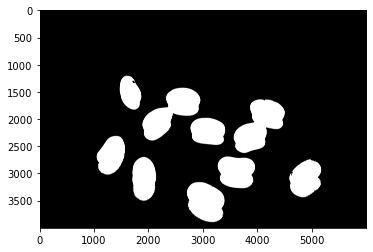

In [28]:
# show the cleared border image
plt.imshow(clear_border, "gray")
plt.show()

In [29]:
# erosion
from skimage.morphology import binary_erosion

In [30]:
# from skimage import morphology

In [31]:
# mainly will use for watershed
import cv2

In [32]:
# pass once through the erosion 
# with an ellipse structuring 
# eroded_img = binary_erosion(clear_border, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))).astype(int)

# maybe repeat the erosion again
# eroded_img = binary_erosion(eroded_img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))).astype(int)

In [33]:
# show the eroded image
# plt.imshow(eroded_img, "gray")

In [34]:
# distance transform
distance = ndimage.distance_transform_edt(clear_border)

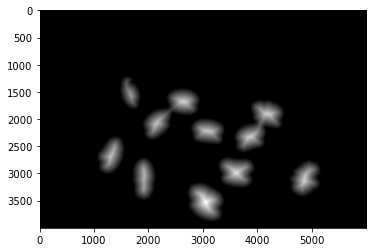

In [35]:
# distance transform image
plt.imshow(distance, "gray")

In [36]:
# distance = distance / np.max(distance)

In [37]:
# need to find a thresholding for this image too
# resort to otsu
img_threshold_distance = threshold_otsu(distance)

In [38]:
# threshold the image
sure_fg = distance > img_threshold_distance

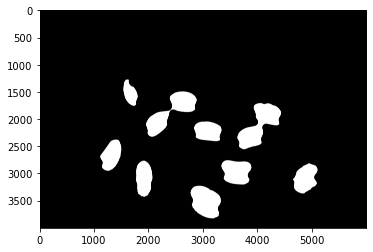

In [39]:
# see the image
plt.imshow(sure_fg, "gray")

In [40]:
# do the erosion twice to get the sure foreground areas
# erosion once
sure_sure_fg = binary_erosion(sure_fg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))).astype(int)
# erosion twice
sure_sure_fg = binary_erosion(sure_sure_fg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))).astype(int)

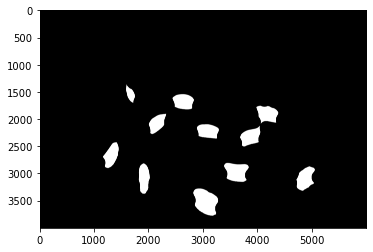

In [41]:
# check the sure foreground
plt.imshow(sure_sure_fg, "gray")

In [42]:
# what is the sure background
sure_bg = clear_border

In [43]:
# unknown part is sure_bg - sure_fg
unknown = cv2.subtract(sure_bg,sure_sure_fg)

In [44]:
# make it uint8 - cv2 quirk
unknown = cv2.convertScaleAbs(unknown*255)

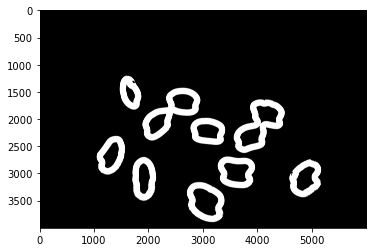

In [45]:
# see the unknown images
plt.imshow(unknown, "gray")

In [46]:
# convert to unint8 again
sure_sure_fg = cv2.convertScaleAbs(sure_sure_fg*255)

In [47]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [48]:
# convert to uint8
gray_image = cv2.convertScaleAbs(gray_image*255)

In [49]:
import numpy as np

In [50]:
# make it 3-D
gray_image = np.dstack([gray_image]*3)

In [51]:
# finally watershed
markers = cv2.watershed(gray_image,markers)

In [52]:
# marker 1 has all the masks
binary_markers = markers == 1

In [53]:
# invert
binary_markers = 1 - binary_markers.astype(int)

In [54]:
# convert to uint8
binary_markers = cv2.convertScaleAbs(binary_markers*255)

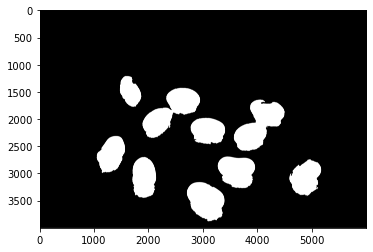

In [55]:
plt.imshow(binary_markers, "gray")

In [56]:
# find the contours
contours, hierarchy = cv2.findContours(binary_markers, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours = contours[0] if len(contours) == 2 else contours[1]

In [57]:
# blank image
blank_image = np.zeros((markers.shape[0], markers.shape[1]))

In [58]:
# a dark image
mask = np.zeros(markers.shape, dtype="uint8")
# iterate over the found markers
for marker in np.unique(markers):
    # markers >=2 are the individual jellybeans
    if marker >= 2:
        # find the mask for the marker
        temp_img = markers == marker
        # convert to uint8
        temp_img = cv2.convertScaleAbs(temp_img*255)
        # detect contour in the mask
        contours, hierarchy = cv2.findContours(temp_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # fit an ellipse to the contour
        e = cv2.fitEllipse(contours[0])
        # get the mask define by the ellipse
        mask=cv2.ellipse(mask, e, color=(255,255,255), thickness=-1)

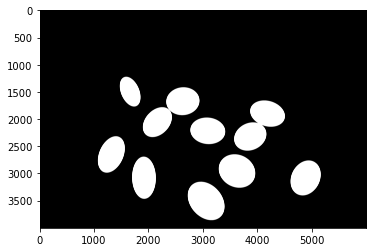

In [59]:
# fine tuned ellipse mask
plt.imshow(mask, "gray")

In [60]:
# pass the mask through find contours
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

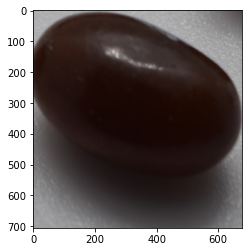

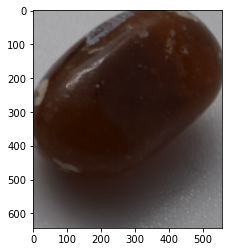

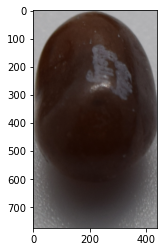

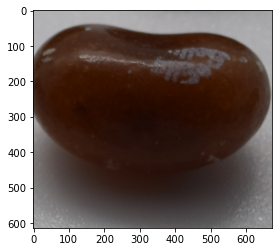

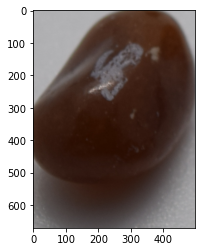

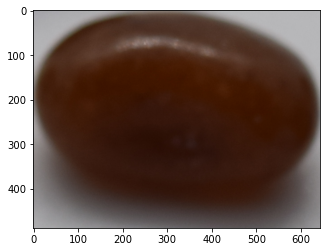

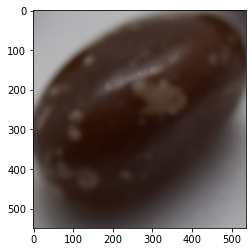

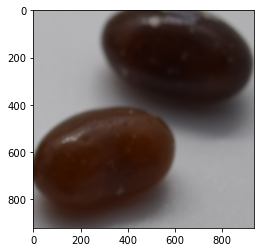

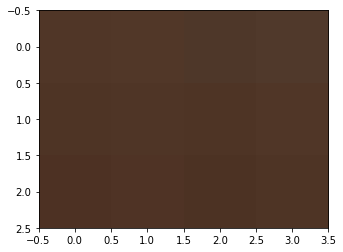

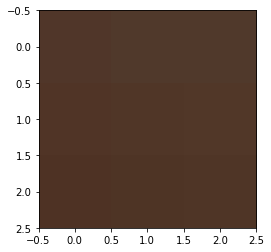

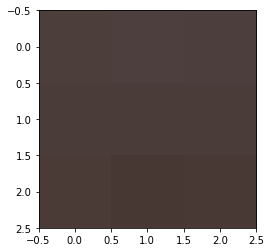

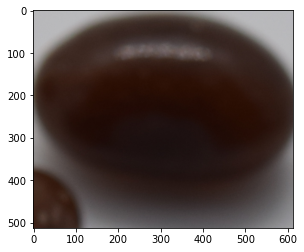

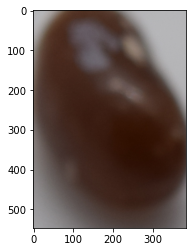

In [61]:
# iterate over the contours and get the RGB jellybean
for cnt in contours: 
    # define a blank image
    blank_image = np.zeros(markers.shape, dtype="uint8")
    # draw the filled contour on the blank image
    jellybean_mask = cv2.drawContours(blank_image, [cnt], -1, (255,255,255), -1)
    
    # draw a rectangle
    x,y,w,h = cv2.boundingRect(cnt)
    
    # get the rectangle image
    rect_img = img[y:y+h,x:x+w]
    
    # Convert mask to boolean array
#     jellybean_mask = np.bool_(jellybean_mask)
    # make the mask 3-D
#     jellybean_mask = np.dstack([jellybean_mask]*3)
    # element wise multiplication to get the jellybean
#     extracted_bean = np.multiply(jellybean_mask, img)
    # show the bean
#     plt.imshow(extracted_bean)
    plt.imshow(rect_img)
    plt.show()

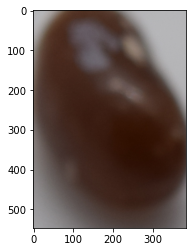

In [62]:
# consider one jellybean
plt.imshow(rect_img)
plt.show()

In [63]:
# HSV
# extracted_bean_hsv = rgb2hsv(rect_img)

In [64]:
# convert to yuv
# extracted_bean_yuv = rgb2yuv(rect_img)

In [65]:
# # write a function that can calculate the mean, sd, and mean/sd for a 3D matrix 
# def function_basic_features(matrix, type_name):
#     # this list will hold all of the engineered features for the channels
#     dict_catch = []
#     # iterate over the channels
#     for index in range(3): 
#         # extract the channel name
#         name = type_name[index]
#         # extract the matrix
#         matrix_name = matrix[:,:,index].ravel()
#         # get the mean
#         matrix_mean = matrix_name.mean()
#         # get the sd
#         matrix_sd = matrix_name.std()
#         # get the ratio
#         matrix_mean_by_sd = matrix_mean/matrix_sd
#         # add to a dictionary
#         dict1 = {"mean_" + name: matrix_mean, "sd_" + name: matrix_sd, "matrix_mean_by_sd_"+ name: matrix_mean_by_sd}
#         # add the dictionary to the list
#         dict_catch.append(dict1)
#     # return the list
#     return(dict_catch)

In [66]:
# features for RGB
# function_basic_features(rect_img, "RGB")

In [67]:
# features for HSV
# function_basic_features(extracted_bean_hsv, "HSV")

In [68]:
# features for YUV
# function_basic_features(extracted_bean_yuv, "YUV")